In [1]:
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [2]:
path = '/home/brian/Documents/CPS/data/clean/'

cols = ['LFS', 'BASICWGT', 'PWSSWGT', 'AGE', 'MONTH', 'YEAR', 'FEMALE']

df = pd.concat([pd.read_feather(f'{path}cps{year}.ft', columns=cols) 
                for year in range(1989, 2021)], sort=False)

df['WGT'] = np.where(df['YEAR'] > 1993, df['PWSSWGT'], df['BASICWGT'])
df['DATE'] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=1))
data = df.groupby(['DATE', 'LFS']).WGT.sum().unstack().rename({'nan': 'Children'}, axis=1) / 1000000
file = '/home/brian/Documents/uschartbook/chartbook/data/cps_lfs.csv'
data.to_csv(file, index_label='date')

datelt = data.index[-1].strftime('%B %Y')

datepr = f"{data.index[-13].strftime('%B %Y')} to {datelt}"

write_txt(text_dir / 'cps_lfs_date.txt', datelt)

write_txt(text_dir / 'cps_lfs_datepr.txt', datepr)

epop = data["Employed"].iloc[-1] / data.iloc[-1].sum() * 100

In [3]:
text = (f'As of {datelt}, {data["Employed"].iloc[-1]:.1f} million '+
        'people are employed (including self-employment). ')

file = '/home/brian/Documents/uschartbook/chartbook/text/cps_lfs0.txt'
with open(file, 'w') as wf:
    wf.write(text)


text = ('Labor provided within a household is not captured by GDP compilation '+
        'methods (expenditures, output, or income), though household surveys '+
        'offer some insight into this important category of labor. The '+
        'number of people who are considered employed divided by the total '+
        'population is the employment rate or employment-to-population ratio, '+
        f'which is {epop:.1f} percent as of {datelt}.')


file = '/home/brian/Documents/uschartbook/chartbook/text/cps_lfs.txt'
with open(file, 'w') as wf:
    wf.write(text)

unemp = (data["Unemployed"].iloc[-1] / (data["Unemployed"].iloc[-1] + data["Employed"].iloc[-1])) * 100
lfpr = (data["Unemployed"].iloc[-1] + data["Employed"].iloc[-1]) / data.iloc[-1].sum() * 100

text = (f'As of {datelt}, there are {data["Unemployed"].iloc[-1]:.1f} million '+
        'unemployed people. The combined group of employed and unemployed people '+
        'is the labor force. The number of unemployed people divided by the number '+
        f'of people in the labor force is the unemployment rate, currently {unemp:.1f} percent. '+
        'The number of people in the labor force divided by the total population is the '+
        f'labor force participation rate, currently {lfpr:.1f} percent.')

text

'As of May 2020, there are 20.7 million unemployed people. The combined group of employed and unemployed people is the labor force. The number of unemployed people divided by the number of people in the labor force is the unemployment rate, currently 13.0 percent. The number of people in the labor force divided by the total population is the labor force participation rate, currently 48.8 percent.'

In [4]:
file = '/home/brian/Documents/uschartbook/chartbook/text/cps_lfs2.txt'
with open(file, 'w') as wf:
    wf.write(text)
    
cols2 = cols + ['NILFREASON']

datalt = cps_12mo(cps_dir, cps_date(), cols2)

student = (datalt.query('MONTH == 12 and NILFREASON == "School"').PWSSWGT.sum() / 1000000)
care = (datalt.query('MONTH == 12 and NILFREASON == "Family"').PWSSWGT.sum() / 1000000)
disill = (datalt.query('MONTH == 12 and NILFREASON == "Disabled/Ill"').PWSSWGT.sum() / 1000000)
disc = (datalt.query('MONTH == 12 and NILFREASON == "Discouraged"').PWSSWGT.sum() / 1000000)
ret = (datalt.query('MONTH == 12 and NILFREASON == "Retired"').PWSSWGT.sum() / 1000000)

In [5]:
nilfpop = data[['NILF', 'Children']].iloc[-1].sum()
text = ('This category is about half of the population, on average, and '+
        f'totals {nilfpop:.1f} million in {datelt}. The '+
        f'category is comprised of children ({data["Children"].iloc[-1]:.1f}'+
        f' million), students ({student:.1f} million), unpaid caregivers '+
        f'({care:.1f} million), those unable to work due to disability or illness '+
        f'({disill:.1f} million), those who want a job but have given up looking ({disc:.1f} '+
        f'million), and retirees and the elderly ({ret:.1f} million).')

file = '/home/brian/Documents/uschartbook/chartbook/text/cps_lfs3.txt'
with open(file, 'w') as wf:
    wf.write(text)
    
data['Total'] = data[['Employed', 'Unemployed', 'NILF']].sum(axis=1)
result = data.drop('Children', axis=1).resample('QS').mean()

file = '/home/brian/Documents/uschartbook/chartbook/data/cps_lfs2.csv'
growth_contrib_ann(result, 'Total').to_csv(file, index_label='date')

print(text)

This category is about half of the population, on average, and totals 166.0 million in May 2020. The category is comprised of children (60.3 million), students (19.0 million), unpaid caregivers (12.0 million), those unable to work due to disability or illness (14.6 million), those who want a job but have given up looking (4.3 million), and retirees and the elderly (47.3 million).


### LFS Table

In [6]:
cols = ['LFS', 'PWSSWGT', 'PWSSWGT', 'AGE', 'MONTH', 'YEAR', 'MJH',
        'FEMALE', 'NILFREASON', 'UNEMPTYPE', 'PTECON', 'WORKFT']

df = cps_1mo(cps_dir, cps_date(), cols).query('AGE >= 15')
df2 = cps_1mo(cps_dir, cps_date() - pd.DateOffset(years=1), cols).query('AGE >= 15')

In [7]:
age_groups = [(15, 30), (30, 60), (60, 86)]
sex = [0, 1]
d = {'Population': {'query': 'PWSSWGT > 0'}, 
     '\hspace{2mm}Employed': {'query': 'LFS == "Employed"'}, 
     '\hspace{4mm}Multiple jobs': {'query': 'MJH == 1'},     
     '\hspace{4mm}Full-time': {'query': 'WORKFT == 1'},  
     '\hspace{4mm}Part-time': {'query': 'WORKFT == 0'}, 
     '\hspace{6mm}Economic reasons': {'query': 'PTECON == 1'},
     '\hspace{2mm}Unemployed': {'query': 'LFS == "Unemployed"'}, 
     '\hspace{2mm}Not in Labor Force': {'query': 'LFS == "NILF"'}, 
     '\hspace{4mm}Discouraged': {'query': 'NILFREASON == "Discouraged"'}, 
     '\hspace{4mm}Disabled/Ill': {'query': 'NILFREASON == "Disabled/Ill"'}, 
     '\hspace{4mm}Family/Care': {'query': 'NILFREASON == "Family"'}, 
     '\hspace{4mm}School': {'query': 'NILFREASON == "School"'}, 
     '\hspace{4mm}Retirement': {'query': 'NILFREASON == "Retired"'}}

d2 = {k: {} for k, v in d.items()}

lf_groups = list(zip(d.keys(), [d[i]['query'] for i in d.keys()])) 

for name, query in lf_groups:
    totval = df.query(query).PWSSWGT.sum()/1000
    d[name]['Total, 15+'] = f'{totval:,.0f}'
    chval = totval - df2.query(query).PWSSWGT.sum()/1000
    d2[name]['Total, 15+'] = f'{chval:,.0f}'

for sex, (agemin, agemax) in itertools.product(sex, age_groups):
    data = df.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    data2 = df2.query('@agemin <= AGE < @agemax and FEMALE == @sex')
    group = f'{["Women" if sex==1 else "Men"][0]}, {agemin}--{agemax-1}'.replace('--85', '+')
    for name, query in lf_groups:
        tmp = data.query(query).PWSSWGT.sum()/1000
        tmp2 = data2.query(query).PWSSWGT.sum()/1000
        d[name][group] = f'{tmp:,.0f}'
        d2[name][group] = f'{tmp - tmp2:,.0f}'

In [8]:
file = '/home/brian/Documents/uschartbook/chartbook/data/lfs_table1.tex'
(pd.DataFrame(d).T.drop('query', axis=1).to_csv(file, 
    sep='&', line_terminator='\\\ ', quotechar=' '))
file = '/home/brian/Documents/uschartbook/chartbook/data/lfs_table2.tex'
pd.DataFrame(d2).T.to_csv(file, sep='&', line_terminator='\\\ ', quotechar=' ')

### Employment rates by age, gender, education

In [9]:
cols = ['MONTH', 'YEAR', 'LFS', 'PWSSWGT', 'AGE', 'EDUC', 'FEMALE']
df1 = pd.read_feather(cps_dir / 'cps2000.ft', columns=cols).query('PWSSWGT > 0')
df2 = cps_12mo(cps_dir, cps_date(), cols)

In [10]:
ages = [(16, 24), (25, 34), (35, 44), (45, 54), (55, 64), (65, 74)]
educ = [['LTHS', 'HS'], ['SC'], ['COLL', 'ADV'], ['LTHS', 'HS', 'SC', 'COLL', 'ADV']]
sex = [0, 1]

In [11]:
results = pd.DataFrame()
for a, e, s in itertools.product(ages, educ, sex):
    row_name = f'{a[0]}-{a[1]}'
    for yr, df in [('2000', df1), ('Latest', df2)]:
        col_name = f'{yr} {" or ".join(e)} {["Female" if s == 1 else "Male"][0]}'
        data = df.query('@a[0] <= AGE <= @a[1] and EDUC in @e and FEMALE == @s')
        i = data.groupby('LFS').PWSSWGT.sum()
        results.loc[row_name, col_name] = (i.Employed / i.sum()) * 100

In [12]:
results.iloc[1:, :-4].to_csv(data_dir / 'empgroups.csv', index_label='name')
results.iloc[:, -4:].to_csv(data_dir / 'empgroups2.csv', index_label='name')

### Union Membership

In [13]:
union_membership_rate = lambda x: np.average(x['UNIONMEM'], weights=x['PWORWGT'])
union_coverage_rate = lambda x: np.average(x['UNION'], weights=x['PWORWGT'])

unmem, uncov = pd.Series(), pd.Series()

untot, nuntot = pd.Series(), pd.Series()

columns = ['MONTH', 'YEAR', 'LFS', 'PWORWGT', 'UNION', 'UNIONMEM']
for year in range(1989, 2021):
    df = (pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
        .query('LFS == "Employed" and UNION in [0, 1]'))
    data1 = df.groupby(['YEAR', 'MONTH']).apply(union_membership_rate)
    data1.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data1.index]
    unmem = unmem.append(data1)
    data2 = df.groupby(['YEAR', 'MONTH']).apply(union_coverage_rate)
    data2.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data2.index]
    uncov = uncov.append(data2)
    df2 = df.query('UNIONMEM == 1')   
    data3 = df2.groupby(['YEAR', 'MONTH']).PWORWGT.sum()
    data3.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data3.index]
    untot = untot.append(data3)
    df3 = df.query('UNIONMEM == 0')
    data4 = df3.groupby(['YEAR', 'MONTH']).PWORWGT.sum()
    data4.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data4.index]
    nuntot = nuntot.append(data4)    
    
data = pd.DataFrame({'Membership': unmem, 'Coverage': uncov})
levels = pd.DataFrame({'Union': untot, 'Nonunion': nuntot})
data['Diff'] = data['Coverage'] - data['Membership']
final = (data.rolling(12).mean().dropna() * 100)
final.to_csv(data_dir / 'union.csv', index_label='date', float_format='%g')
final2 = (levels.rolling(12).mean().dropna()) / 1000000

ltdate = final.index[-1].strftime('%B %Y')
prevdate = final.index[-13].strftime('%B %Y')
prev2date = final.index[-25].strftime('%B %Y')

ltval = final['Membership'].iloc[-1]
prevval = final['Membership'].iloc[-13]
prev2val = final['Membership'].iloc[-25]

totvallt = final2['Union'].iloc[-1]
totnvallt = final2['Nonunion'].iloc[-1]

chlt = final2['Union'].diff(12).iloc[-1] * 1000000
chpr = final2['Union'].diff(12).iloc[-13] * 1000000

chnlt = final2['Nonunion'].diff(12).iloc[-1] * 1000000
chnpr = final2['Nonunion'].diff(12).iloc[-13] * 1000000

<ipython-input-13-cf3c89eaaab5>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  unmem, uncov = pd.Series(), pd.Series()
<ipython-input-13-cf3c89eaaab5>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  untot, nuntot = pd.Series(), pd.Series()


In [14]:
if chlt > 10:
    chlt_txt = f'increased by {round(chlt, -3):,.0f}'
elif chlt <= -10:
    chlt_txt = f'decreased by {abs(round(chlt, -3)):,.0f}'
else:
    chlt_txt = 'were virtually unchanged'
    
if chnlt > 10:
    chnlt_txt = f'increased by {round(chnlt, -3):,.0f}'
elif chnlt <= -10:
    chnlt_txt = f'decreased by {abs(round(chnlt, -3)):,.0f}'
else:
    chnlt_txt = 'were virtually unchanged'

In [15]:
text = (f'Over the 12 months ending {ltdate}, the share of jobs held '+
        f'by union and employee association members averaged {ltval:.1f} percent. '+
        f'In levels, there were {totvallt:.1f} million union jobs, and '+
        f'{totnvallt:.1f} million nonunion jobs, on average over the period. '+
        f'This union membership rate averaged {prevval:.1f} percent during the 12 '+
        f'months ending {prevdate}, and {prev2val:.1f} percent during the 12 '+
        f'months ending {prev2date}. Union jobs {chlt_txt} '+
        f'from {prevdate} to {ltdate}, while nonunion jobs {chnlt_txt}.')

write_txt(text_dir / 'union.txt', text)

text

'Over the 12 months ending May 2020, the share of jobs held by union and employee association members averaged 10.5 percent. In levels, there were 14.5 million union jobs, and 123.9 million nonunion jobs, on average over the period. This union membership rate averaged 10.4 percent during the 12 months ending May 2019, and 10.7 percent during the 12 months ending May 2018. Union jobs decreased by 179,000 from May 2019 to May 2020, while nonunion jobs decreased by 2,274,000.'

In [16]:
union_membership_rate = lambda x: np.average(x['UNIONMEM'], weights=x['PWORWGT']) * 100
columns = ['MONTH', 'YEAR', 'LFS', 'PWORWGT', 'UNIONMEM', 'INDGRP']

df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=columns)
                  .query('PWORWGT > 0 and UNIONMEM == UNIONMEM')
      for year in range(1989, 2021)])

df.INDGRP.cat = df.INDGRP.cat.remove_unused_categories()

data = df.groupby(['YEAR', 'MONTH', 'INDGRP']).apply(union_membership_rate).unstack()
data.index = [pd.to_datetime(f'{ti[0]}-{ti[1]}-01') for ti in data.index]
data.index.name = 'date'
data.columns.name = None
prev12 = data.iloc[-12:].mean()
lval = data.iloc[-1]
minval = data.min()
maxval = data.max()
width = maxval - minval
final = pd.concat([lval, prev12, minval, maxval, width], axis=1)
final.columns = ['latest', 'prev12', 'min', 'max', 'width']
final.index.name = 'name'
final = final[['min', 'width', 'latest']].sort_values('latest', ascending=False)
final['y'] = [0.13, -0.87, -1.87, -2.87, -3.87, -4.87, -5.87]
final.to_csv(data_dir / 'union_ind.csv', sep=';')

In [17]:
dec = (maxval - lval).sort_values()
dec1 = dec.index[-1]
decval1 = dec[-1]
decmaxdt = dtxt(data[dec1].idxmax())['mon1']
decmaxval = data[dec1].max()
decgrp = dec1.lower()
lowgroupmaxdt = dtxt(data[final.index[-1]].idxmax())['mon1']
lowgrp = final.index[-1].lower()


text = (f'{final.index[0]} has the highest union membership rate, '+
        f'at {final.latest.iloc[0]:.1f} percent as of {ltdate}, followed by '+
        f'{final.index[1].lower()} with {final.latest.iloc[1]:.1f} percent, '+
        f'and {final.index[2].lower()} with {final.latest.iloc[2]:.1f} percent. '+
        f'The {decgrp} industry '+
        'experienced the largest overall percentage point decrease '+
        'in union membership rates over the past 30 years, and is '+
        f'currently {decval1:.1f} percentage points below its {decmaxdt} '+
        f'rate of {decmaxval:.1f} percent. ')
txt2 = ('The lowest union membership rate '+
        f'is in {lowgrp} ({final.latest.iloc[-1]:.1f} percent). '+
        f'The union membership rate of the industry was {data[final.index[-1]].max():.1f} '+
        f'percent at its 30-year peak in {lowgroupmaxdt}. ')

mfglt = data['Manufacturing'].iloc[-1]
mfgpr = data['Manufacturing'].iloc[-13]
prdt = dtxt(data.index[-13])['mon1']
mfgpr2 = data['Manufacturing'].iloc[-25]
prdt2 = dtxt(data.index[-25])['mon1']

txt3 = (f'The manufacturing industry union membership rate was {mfglt:.1f} percent in {ltdate}, '+
        f'{mfgpr:.1f} percent in {prdt}, and {mfgpr2:.1f} percent in {prdt2}.')

if lowgrp == decgrp:
    text = text + txt3
else:
    text = text + txt2

write_txt(text_dir / 'union_ind.txt', text)

text

'Public administration has the highest union membership rate, at 28.3 percent as of May 2020, followed by education and health with 18.2 percent, and construction and mining with 11.6 percent. The leisure and hospitality industry experienced the largest overall percentage point decrease in union membership rates over the past 30 years, and is currently 16.4 percentage points below its January 1989 rate of 18.0 percent. The manufacturing industry union membership rate was 10.2 percent in May 2020, 11.2 percent in May 2019, and 10.1 percent in May 2018.'

### Matching YY -- Disability to Work Flows

Over the year ending May 2020, 9.0 percent of persons age 25--54 who were out of the labor force due to disability or illnessin the prior year are now employed (see {\color{blue}\textbf{---}}). This one-year rate of job-finding has increased substantially from its 2010--2013 average of 5.8 percent


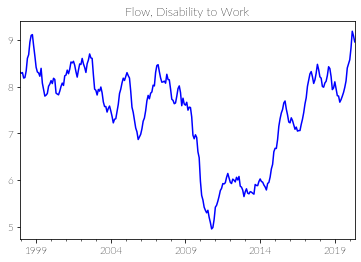

In [18]:
cols = ['CPSID', 'AGE', 'FEMALE', 'WBHAO', 'NILFREASON', 
        'LFS', 'MIS', 'BASICWGT', 'PULINENO']

emp = lambda x: np.where(x.LFS_y == 'Employed', 1, 0)

dates = pd.date_range('1997-01-01', cps_date(), freq='MS')

d = {}

for dt in dates:
    df1 = (cps_1mo(cps_dir, dt - pd.DateOffset(years=1), cols)
           .query('NILFREASON == "Disabled/Ill"'))
    df2 = cps_1mo(cps_dir, dt, cols)
    data = (pd.merge(df1, df2, on=['CPSID', 'PULINENO', 'FEMALE', 'WBHAO'])
              .query('25 <= AGE_y <= 54'))
    data = (data.loc[(data.AGE_x <= data.AGE_y) & 
                     (data.AGE_y - 2 <= data.AGE_x)]).assign(EMP = emp)

    d[dt] = np.average(data.EMP, weights=data.BASICWGT_y) * 100
    
df = pd.Series(d).rolling(12).mean().dropna().rename('Share')

df.to_csv(data_dir / 'disflow.csv', index_label='date', header=True)
write_txt(text_dir/ 'disflow_node.txt', end_node(df, 'blue'))

latest = df.iloc[-1]
valavg = df.loc['2010-12-01':'2013-12-01'].mean()
ltdate = dtxt(df.index[-1])['mon1']

text = (f'Over the year ending {ltdate}, {latest:.1f} percent of '+
        'persons age 25--54 who were out of the labor force due to disability or illness'+
        'in the prior year are now employed (see {\color{blue}\\textbf{---}}). '+
        'This one-year rate of job-finding has increased '+
        f'substantially from its 2010--2013 average of {valavg:.1f} percent')

write_txt(text_dir / 'disflow.txt', text)

print(text)
df.plot(color='blue', title='Flow, Disability to Work');

### CPS Labor Force Nonparticipation by Reason

Brian Dew, @bd_econ

Replaces CPS_PrimeLF_Contrib.ipynb

March 19, 2019

Replication using python of a very clever chart by Ernie Tedeschi (@ernietedeschi).

[Definitions](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of labor market status come from the FRB of Atlanta.

In [19]:
os.chdir(cps_dir)

def to_date(ym):
    return pd.to_datetime(f'{ym[0]}-{ym[1]}-01')

years = range(2000, 2021)
ref_pd = (2001, 3)
ref_dt = to_date(ref_pd)
ages = '18 <= AGE <= 64'
wgt = 'BASICWGT'
cat = 'NILFREASON'
dates = ['YEAR', 'MONTH']
dems = ['FEMALE', 'AGE']
cols = dates + dems + [wgt, cat]
files = [f'cps{year}.ft' for year in years]

# CPS Data
df = pd.concat([pd.read_feather(file, columns=cols)
                  .query(ages) for file in files])

p = df.groupby(dates + dems)[wgt].sum().rename('ADJ')
sh = (p / p.groupby(dates).sum())
adj = (sh.loc[ref_pd] / sh).reset_index()
data = (pd.merge(df, adj)
          .assign(ADJWGT = lambda x: x.ADJ * x[wgt]))
data.NILFREASON.cat.rename_categories({'nan': 'LF'}, 
                                      inplace=True)

# Make Adjustments
c = data.groupby(dates + [cat]).ADJWGT.sum()
dem_res = (c / c.groupby(dates).sum()).unstack()
dem_res.columns = dem_res.columns.to_list()

c_nd = data.groupby(dates + [cat])[wgt].sum()
nd_res = (c_nd / c_nd.groupby(dates).sum()).unstack()

dem_res['Demographics'] = dem_res['LF'] - nd_res['LF']
dem_res.index = [to_date(ym) for ym in dem_res.index]

keep_cols = dem_res.columns.difference(['LF'])
result = (dem_res.rolling(12).mean().dropna()
                 .loc[ref_dt:, keep_cols] * 100)

final = result.iloc[0] - result

#### Export result

In [20]:
os.chdir('/home/brian/Documents/uschartbook/chartbook/')

final.to_csv('data/nilf.csv', index_label='date')

colors = {'Disabled/Ill': 'green!80!blue', 
          'Discouraged': 'blue', 
          'Family': 'red', 
          'Retired': 'orange', 
          'School': 'cyan', 
          'Demographics': 'violet!80!purple'}

node_file = open('text/nilf_nodes.txt', 'w')
for series, color in colors.items():
    node_file.write(end_node(final[series], color, percent=False))
node_file.close()

#### Text

In [21]:
ltdate = dtxt(cps_date())['mon1']

lt = final.iloc[-1]
tot = abs(lt.sum())
dem = abs(lt['Demographics'])
demc = colors['Demographics']
sch = abs(lt['School'])
schc = colors['School']
dis = abs(lt['Disabled/Ill'])
disc = colors['Disabled/Ill']
ret = abs(lt['Retired'])
retc = colors['Retired']

text = (f'From March 2001 to the latest available twelve months of data, '+''+
        f'ending {ltdate}, an additional {tot:.1f} percent of the age 18--64 '+
         'population left the labor force. Changes in the demographic '+
         'composition of the population affect the rate of participation. '+
         'For example, the larger-than-normal population '+
         'cohort born after World War II is reaching retirement age in '+
        f'this period. Changes in the age and sex distribution explain {dem:.1f} '+
         'percentage points of the cumulative decrease since March 2001 '+
        f'(see {{\color{{{demc}}}\\textbf{{---}}}}). \\\\ \n\nAdditionally, '+ 
         'young people are staying in school longer, on average, '+
        f'reducing the age 18--64 labor force by {sch:.1f} percent '+
        f'(see {{\color{{{schc}}}\\textbf{{---}}}}). '+
         'Disability and illness reduce the labor force by '+
        f'another {dis:.1f} percent '+
        f'(see {{\color{{{disc}}}\\textbf{{---}}}}). Less retirement among those age '+
        f'18--64 increases the labor force by {ret:.1f} percent, over '+
        f'the period (see {{\color{{{retc}}}\\textbf{{---}}}}).')


write_txt('text/nilf_01.txt', text)

print(text)

From March 2001 to the latest available twelve months of data, ending May 2020, an additional 2.8 percent of the age 18--64 population left the labor force. Changes in the demographic composition of the population affect the rate of participation. For example, the larger-than-normal population cohort born after World War II is reaching retirement age in this period. Changes in the age and sex distribution explain 1.1 percentage points of the cumulative decrease since March 2001 (see {\color{violet!80!purple}\textbf{---}}). \\ 

Additionally, young people are staying in school longer, on average, reducing the age 18--64 labor force by 1.7 percent (see {\color{cyan}\textbf{---}}). Disability and illness reduce the labor force by another 0.6 percent (see {\color{green!80!blue}\textbf{---}}). Less retirement among those age 18--64 increases the labor force by 0.8 percent, over the period (see {\color{orange}\textbf{---}}).


#### Bar Chart

In [22]:
os.chdir(cps_dir)

result, share = pd.DataFrame(), pd.DataFrame()

dts = [cps_date(), cps_date() - pd.DateOffset(years=1)]

for date in dts:
    month =  date.month
    year = date.year
    data = (pd.read_feather(f'cps{year}.ft', columns=cols)
              .query('YEAR == @year and MONTH == @month'))
    
    dt = dtxt(date)['mon1']

    result[dt] = data.groupby('NILFREASON').BASICWGT.sum()
    share[dt] = result[dt] / result[dt].sum() * 100
    
os.chdir(cb_dir)

mo1 = dtxt(dts[0])['mon1']
mo2 = dtxt(dts[1])['mon1']

(share.drop('nan').round(1).sort_values(mo1, ascending=False)
       .to_csv(data_dir / 'nilf_comp.csv', index_label='name'))

write_txt(text_dir / 'nilf_mo1.txt', mo1)
write_txt(text_dir / 'nilf_mo2.txt', mo2)

pct = share[mo1]
pctpr = share[mo2]
lev = result[mo1] / 1_000_000

totlev = lev.drop('nan').sum()
totpct = pct.drop('nan').sum()
totpctpr = pctpr.drop('nan').sum()
retpct = pct['Retired']
dislev = lev['Disabled/Ill']
dispct = pct['Disabled/Ill']
schpct = pct['School']
carepct = pct['Family']

text = ('These labor force non-participants, which do not include '+
        f'those under the age of 15, total {totlev:.1f} million '+
        f'in {mo1}, or {totpct:.1f} percent of the age 15 or older '+
        f'population, compared to {totpctpr:.1f} percent in {mo2}. '+
         'Slightly less than half of non-participants, and '+
        f'{retpct:.1f} percent of population, are retirees in {mo1} '+
        '(see\cbox{green!80!blue!75!black}). A total of '+
        f'{dislev:.1f} million people, or {dispct:.1f} percent of the age '+
         '15 or older population, are out of the labor force due to disability '+
        f'or illness; {schpct:.1f} percent were out of the labor force for '+
        f'school, and {carepct:.1f} percent for family or caregiving reasons.')

write_txt(text_dir / 'nilfbasic.txt', text)

text

'These labor force non-participants, which do not include those under the age of 15, total 102.1 million in May 2020, or 39.3 percent of the age 15 or older population, compared to 37.2 percent in May 2019. Slightly less than half of non-participants, and 19.0 percent of population, are retirees in May 2020 (see\\cbox{green!80!blue!75!black}). A total of 13.4 million people, or 5.1 percent of the age 15 or older population, are out of the labor force due to disability or illness; 5.5 percent were out of the labor force for school, and 4.9 percent for family or caregiving reasons.'